In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
with open('xtrain.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('xtest.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('ytrain.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('ytest.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
print("Total number of training sample: ",X_train.shape[0])
print("Total number of testing example: ",X_test.shape[0])
X_train.shape

Total number of training sample:  3888
Total number of testing example:  432


(3888, 162)

In [ ]:
# Verify data shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {len(y_train)}")
print(f"y_test shape: {len(y_test)}")

X_train shape: (3888, 162)
X_test shape: (432, 162)
y_train shape: 3888
y_test shape: 432


In [ ]:
# Get number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
Y_train = le.fit_transform(y_train)
Y_test = le.fit_transform(y_test)

In [ ]:
# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
y_test_encoded = to_categorical(Y_test, num_classes=num_classes)

In [ ]:
# Reshape data for LSTM [samples, timesteps, features]
def prepare_data(X, timesteps=5):
    X_reshaped = []

    for i in range(len(X) - timesteps + 1):
        X_reshaped.append(X[i:i+timesteps])

    return np.array(X_reshaped)

In [ ]:
# Prepare data for LSTM
timesteps = 5  # You can adjust this
X_train_reshaped = prepare_data(X_train, timesteps)
X_test_reshaped = prepare_data(X_test, timesteps)
y_train_reshaped = y_train_encoded[timesteps-1:]
y_test_reshaped = y_test_encoded[timesteps-1:]

print(f"Reshaped X_train: {X_train_reshaped.shape}")
print(f"Reshaped X_test: {X_test_reshaped.shape}")
print(f"Reshaped y_train: {y_train_reshaped.shape}")
print(f"Reshaped y_test: {y_test_reshaped.shape}")

Reshaped X_train: (3884, 5, 162)
Reshaped X_test: (428, 5, 162)
Reshaped y_train: (3884, 7)
Reshaped y_test: (428, 7)


In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(timesteps, 162), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Print model summary
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 5, 128)              │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,607 (787.53 KB)

 Trainable params: 201,159 (785.78 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [ ]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train_reshaped,
    validation_data=(X_test_reshaped, y_test_reshaped),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.1536 - loss: 2.5358 - val_accuracy: 0.2243 - val_loss: 1.9248 - learning_rate: 0.0010
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1921 - loss: 2.1295 - val_accuracy: 0.2734 - val_loss: 1.8710 - learning_rate: 0.0010
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2442 - loss: 1.9430 - val_accuracy: 0.2850 - val_loss: 1.8250 - learning_rate: 0.0010
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2713 - loss: 1.8640 - val_accuracy: 0.3341 - val_loss: 1.7591 - learning_rate: 0.0010
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.3063 - loss: 1.7670 - val_accuracy: 0.3528 - val_loss: 1.6694 - learning_rate: 0.0010
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.3580 - loss: 1.6573 - val_accuracy: 0.3528 - val_loss: 1.6205 - learning_rate: 0.0010
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.3800 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.1440
Test Accuracy: 0.5981


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        64
           1       0.55      0.54      0.54        56
           2       0.70      0.60      0.64        62
           3       0.46      0.44      0.45        55
           4       0.69      0.74      0.71        92
           5       0.36      0.46      0.40        46
           6       0.58      0.62      0.60        53

    accuracy                           0.60       428
   macro avg       0.59      0.58      0.58       428
weighted avg       0.61      0.60      0.60       428



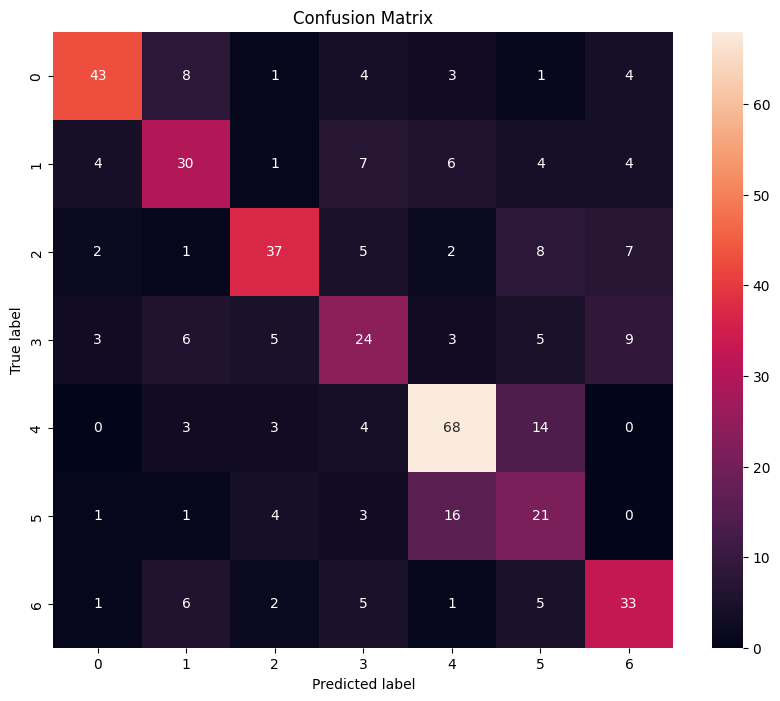

In [ ]:
# Make predictions
predictions = model.predict(X_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_reshaped, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()